In [1]:
import numpy
import pandas as pd
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras.optimizers import SGD, Adam
from keras.losses import Huber
from numpy.lib.stride_tricks import sliding_window_view

In [2]:
def get_historic_data(symbol):
    ticker = symbol
    iex_api_key = 'Tsk_30a2677082d54c7b8697675d84baf94b'
    api_url = f'https://sandbox.iexapis.com/stable/stock/{ticker}/chart/max?token={iex_api_key}'
    df = requests.get(api_url).json()

    date = []
    open = []
    high = []
    low = []
    close = []

    for i in range(len(df)):
        date.append(df[i]['date'])
        open.append(df[i]['open'])
        high.append(df[i]['high'])
        low.append(df[i]['low'])
        close.append(df[i]['close'])

    date_df = pd.DataFrame(date).rename(columns={0: 'date'})
    open_df = pd.DataFrame(open).rename(columns={0: 'open'})
    high_df = pd.DataFrame(high).rename(columns={0: 'high'})
    low_df = pd.DataFrame(low).rename(columns={0: 'low'})
    close_df = pd.DataFrame(close).rename(columns={0: 'close'})

    frames = [date_df, open_df, high_df, low_df, close_df]
    df = pd.concat(frames, axis=1, join='inner')
    df = df.set_index('date')

    close_df.plot()
    plt.title('{} Historical Prices'.format(ticker), fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Stock Price', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    return close_df

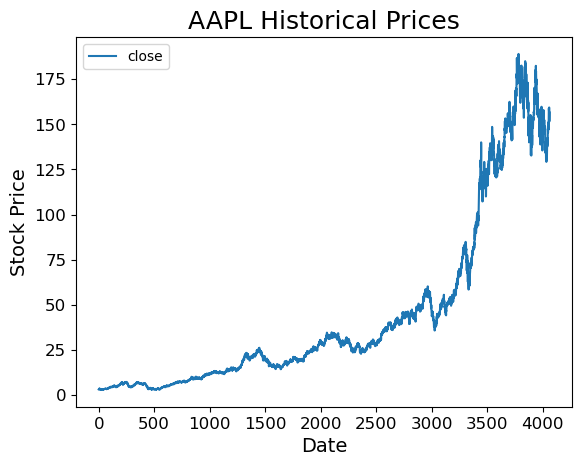

In [3]:
batch_size = 64
tensor_slices = get_historic_data("AAPL")
max_closing_price = tensor_slices['close'].max()
window_length = 256
train_dataset_length = 3000

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(tensor_slices.to_numpy()[-train_dataset_length:])
dataset = dataset.window(window_length, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
dataset = dataset.batch(batch_size=batch_size).prefetch(1)
dataset_shuffled = dataset.shuffle(buffer_size=batch_size+1)

In [5]:
model = tf.keras.models.Sequential([
    layers.Input(shape=[None]),
    layers.Lambda(lambda x: tf.expand_dims(x, axis = -1)),
    layers.LSTM(units=2048, return_sequences=False),
    #layers.LSTM(units=512, return_sequences=False),
    layers.Dense(units=256, activation='relu'),
    #layers.Dense(units = 64, activation='relu'),
    #layers.Dense(units = 8, activation='relu'),
    layers.Dense(1),
    layers.Lambda(lambda x: x*max_closing_price)
])

In [6]:
optimizer = SGD(learning_rate=1e-8, momentum=0.9)

In [7]:
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 2048)              16793600  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 17,318,401
Trainable params: 17,318,401
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.fit(dataset_shuffled, epochs = 30)

Epoch 1/30
43/43 [==============================] - 16s 289ms/step - loss: 48.3302 - mae: 48.8264
Epoch 2/30
43/43 [==============================] - 11s 242ms/step - loss: 17.6346 - mae: 18.1000
Epoch 3/30
43/43 [==============================] - 11s 243ms/step - loss: 4.6499 - mae: 5.1073
Epoch 4/30
43/43 [==============================] - 11s 244ms/step - loss: 4.5856 - mae: 5.0580
Epoch 5/30
43/43 [==============================] - 11s 245ms/step - loss: 3.5149 - mae: 3.9786
Epoch 6/30
43/43 [==============================] - 11s 246ms/step - loss: 3.0246 - mae: 3.4791
Epoch 7/30
43/43 [==============================] - 11s 247ms/step - loss: 2.5187 - mae: 2.9638
Epoch 8/30
43/43 [==============================] - 11s 247ms/step - loss: 2.4140 - mae: 2.8681
Epoch 9/30
43/43 [==============================] - 11s 247ms/step - loss: 2.0227 - mae: 2.4493
Epoch 10/30
43/43 [==============================] - 11s 247ms/step - loss: 1.8717 - mae: 2.2917
Epoch 11/30
43/43 [================

In [9]:
all_prices = numpy.squeeze(tensor_slices.to_numpy())
sliding_window = sliding_window_view(all_prices, window_shape=window_length-1)
sliding_window = numpy.expand_dims(sliding_window, axis=-1)

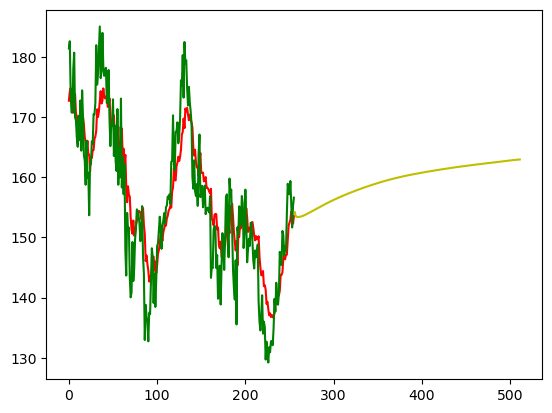

In [12]:
num_predictions = window_length
predictions = model(sliding_window[-window_length-1:-1])
origninal_data = all_prices[-window_length:]
xs = []
ys = []

inputs_all_prices = tf.identity(all_prices)
inputs_all_prices = tf.cast(inputs_all_prices, tf.float32)
inputs_all_prices = tf.expand_dims(inputs_all_prices, axis = -1)


for i in range(num_predictions):
    model_inputs = inputs_all_prices[-window_length:]
    model_inputs = tf.expand_dims(model_inputs, axis = 0)
    prediction = model(model_inputs)
    inputs_all_prices = tf.concat([inputs_all_prices, prediction], axis = 0)
    xs.append(window_length+i)
    ys.append(numpy.squeeze(prediction))
    pass

plt.plot(predictions, color= 'r')
plt.plot(origninal_data, color='g')
plt.plot(xs, ys, color='y')
plt.show()